# Predicting Pet Insurance Claims - Pre-processing
## 1 Introduction
### 1.1 Background
Whenever a pet insurance policy holder incurs veterinary expenses related to their enrolled pet, they can submit claims for reimbursement, and the insurance company reimburses eligible expenses. To price insurance products correctly, the insurance company needs to have a good idea of the amount their policy holders are likely to claim in the future.

### 1.2 Project Goal
The goal of this project is to create a machine learning model to predict how much (in dollars) a given policy holder will claim for during the second year of their policy.

### 1.3 Notebook Goals
* Split data into Train and Test sets
* Complete any remaining feature engineering
* Pre-process the data to prepare for modeling

## 2 Setup
### 2.1 Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### 2.2 Data Load and Preview
At the end of exploratory data analysis, we had an updated data file for our pets data containing all pet records. As a quick review, here's a summary:
* Shape - Our clean dataframe is 50000 rows with each row corresponding to a single pet.
* Basic Info - For each pet, we have some basic info including species, breed, and age at time of enrollment.
* YoungAge - Designation for pets who enrolled at a very young age (< 7 weeks)
* Policy Info - We also have policy-level info for each pet including the monthly premium and deductible amount for claims.
* Claims Data - We also have claims data for each pet covering the first two policy years including:
* Number of claims per year and total (years 1 and 2 combined)
* Average claim amount per year and total (years 1 and 2 combined)
* Amount of claims per year and total (years 1 and 2 combined)

Let's load in the data and preview.

In [2]:
pets = pd.read_csv('../data/pets.csv', index_col=0)
pets.head(8).T

,0,1,2,3,4,5,6,7
PetId,0,1,2,3,4,5,6,7
Species,Dog,Dog,Dog,Dog,Dog,Dog,Cat,Dog
Breed,Schnauzer Standard,Yorkiepoo,Mixed Breed Medium,Labrador Retriever,French Bulldog,Shih Tzu,American Shorthair,Boxer
Premium,84.54,50.33,74.0,57.54,60.69,43.53,47.4,75.14
Deductible,200,500,500,500,700,700,250,700
AgeYr1,3,0,0,0,0,2,0,5
YoungAge,0,0,0,0,0,0,0,0
AmtClaimsYr1,0.0,0.0,640.63,0.0,7212.25,2665.67,0.0,2873.47
AmtClaimsYr2,1242.0,0.0,1187.68,0.0,168.75,0.0,811.38,2497.03
AvgClaimsYr1,0.0,0.0,213.543333,0.0,801.361111,296.185556,0.0,410.495714


### 2.3 Initial Plan for Pre-processing and Feature Engineering
Our primary goal for pre-processing will be to prepare our data for modeling. At a our minimum, this will include scaling and/or normalizing our features against one another, generating any required dummy values for categorical columns and splitting our data into our train and test sets.

**Train / Test Prep**
* Drop all 'Yr2' and 'Total' columns except AmtClaimsYr2 (our target) as this is data we would not have available for making predictions
* Split our data into training and test sets

**Feature Engineering** 
* Premium and Deductible - Roll these features up to the breed level to smooth out some of the variability between pets that are in essence, identical
* Breed - Employ a method to reduce the number of unique values
* Breed statistics - Add features to incorporate breed-related statistics into pets data
* PetAge - Consider adding a new features factoring in age (e.g., average claim amount in year 1, average total claims in year 1 - by age grouping)
* AmtClaimsYr1 and AvgClaimsYr1 - consider rolling these up into one feature or rolling these up by breed
* NumClaimsYr1 - Consider dropping this column or rolling up by breed; Could also be converted to binary (claims and no-claims)

**Pre-processing**
* Species - Convert to binary
* Breed - Create dummy variables for the remaining breeds
* All columns - Scale or normalize any columns not already converted to binary or dummy variables


## 3 Split the Data
As a first step, we'll take care of the train/test split to prevent any data leakage. Before we split the data, we need to drop some of the features that won't be part of our model. 

In addition, we observed in data wrangling and EDA, that there are a wide variety of breeds in our data. If we want to maintain a balanced distribution of breeds after our split, we'll need to use *stratify* to achieve this. Stratify won't work with our current data since we have some breeds with only 1 pet and stratify requires a minimum of 2 in each category.

To work around this, we can take a few steps to reduce the number of unique values for 'Breed'. In doing so, we can ensure a minimum number of pets in each category. 

### 3.1 Drop Unnecessary Features 
We have a number of features in our current dataset that would be unfair to use in our predictive model. The purpose of our model will be to predict claims in year 2. That being the case, we need to remove any features that include data for year 2.

In [3]:
# Drop features that won't be part of the model
drop_cols = ['PetId', 'AvgClaimsYr2', 'NumClaimsYr2', 'AmtClaimsTotal', 'AvgClaimsTotal',
             'NumClaimsTotal', 'YrsWithClaims']
pets.drop(columns=drop_cols, inplace=True)

### 3.2 Reduce the Number of Unique Breeds
To reduce the number of unique breeds in the data, we'll follow the steps below:

1. Set threshold and save a list of breeds with counts greater or equal to the threshold
2. Write a function to update the breed for a row based on whether or not it exists in the list from step 1
3. Create a copy of our original df and apply the function
4. Print out the before and after numbers for our count of unique breeds

As part of step 2 above, we'll update the breed name for breeds with a low pet count to group them together in an *Other* category. To ensure we don't lose any species-specific information, we'll create two versions of *Other*, 'Other Cat' and 'Other Dog'. 

In [4]:
breeds = pd.read_csv('../data/breeds.csv', index_col=0)
breeds.head(10).T

,0,1,2,3,4,5,6,7,8,9
Breed,Abyssinian,Affenpinscher,Afghan Hound,Aidi,Airedale Terrier,Akbash Dog,Akita,Alaskan Klee Kai,Alaskan Malamute,American Bandogge Mastiff
Species,Cat,Dog,Dog,Dog,Dog,Dog,Dog,Dog,Dog,Dog
PetCount,24,3,10,2,41,1,49,30,64,1
AvgTotalClaims,1462.780417,1746.19,645.543,0.0,1338.705366,11383.6,1217.91102,1510.666333,3096.346719,2295.07
AvgNumClaims,4.25,1.333333,2.5,0.0,2.097561,23.0,3.591837,3.166667,3.765625,8.0
WeightedTotalClaims,35106.73,5238.57,6455.43,0.0,54886.92,11383.6,59677.64,45319.99,198166.19,2295.07
WeightedNumClaims,102.0,4.0,25.0,0.0,86.0,23.0,176.0,95.0,241.0,8.0


In [5]:
# Set threshold
threshold = 100

# Preserve list of Breeds with count greater equal to the threshold
breeds_list = breeds[breeds.PetCount >= threshold].Breed.tolist()

# Create function to update breed column based on threshold
def update_breed(row):
    if (row["Breed"] in breeds_list):
        return row["Breed"]
    else:
        if (row["Species"] == 'Cat'):
            return 'Other Cat'
        else:
            return 'Other Dog'

# Print number of unique breeds before update
print("Number of unique breeds before: " + str(pets.Breed.nunique()))

# Apply function to update Breed
pets["Breed"] = pets.apply(update_breed, axis=1)
print("Number of unique breeds after: " + str(pets.Breed.nunique()))

Number of unique breeds before: 373
Number of unique breeds after: 79


### 3.3 Split Data into Train and Test

In [6]:
# Split out target and features
y = pets["AmtClaimsYr2"].values
X = pets.drop(columns="AmtClaimsYr2")

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=pets['Breed'])

In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40000, 9)
(10000, 9)
(40000,)
(10000,)


## 4 Feature Engineering
Now that we've split the data into train and test sets, we can proceed with feature engineering without worrying about data leakage. As a next step, let's replace our **breeds** dataframe (which was based on the entire dataset) with an updated version based on our training dataset. Then we can pull in some of the summary statistics as new features.

* Premium and Deductible - Roll these features up to the breed level to smooth out some of the variability between pets that are in essence, identical
* Breed statistics - Add features to incorporate breed-related statistics into pets data
* PetAge - Consider adding a new features factoring in age (e.g., average claim amount in year 1, average total claims in year 1 - by age grouping)

### 4.1 Breed Statistics
After we create our new dataframe grouped by breed, we'll write a function to pull the summary statistics into our training data. 

In [8]:
# Group pets by breed and aggregate data
breeds = X_train.groupby(by=['Breed', 'Species']).agg({'Breed': ['count'],
                                                       'Premium': ['mean'],
                                                       'Deductible': ['mean'],
                                                       'AmtClaimsYr1': ['mean'],
                                                       'NumClaimsYr1': ['mean'],
                                                       'AvgClaimsYr1': ['mean']}).reset_index()
breeds.columns = ['Breed', 'Species', 'PetCount', 'BreedAvgPremium', 'BreedAvgDeductible',
                  'BreedAvgTotalClaims', 'BreedAvgNumClaims', 'BreedAvgClaimAmt']
breeds.head(10).T

,0,1,2,3,4,5,6,7,8,9
Breed,American Pitbull Terrier,American Shorthair,American Staffordshire Terrier,Aussiedoodle,Australian Labradoodle,Australian Shepherd,Beagle,Bengal,Bernedoodle,Bernese Mountain Dog
Species,Dog,Cat,Dog,Dog,Dog,Dog,Dog,Cat,Dog,Dog
PetCount,270,322,86,83,502,380,199,117,232,255
BreedAvgPremium,93.191259,44.915745,86.559651,58.956988,55.330677,59.679342,78.922965,40.275556,70.899957,104.423412
BreedAvgDeductible,516.944444,440.590062,540.697674,439.759036,484.282869,498.539474,541.683417,445.299145,478.060345,611.294118
BreedAvgTotalClaims,1550.556815,361.801584,1329.012907,461.165904,616.1949,599.823632,1005.977186,801.852051,831.944784,1423.842235
BreedAvgNumClaims,2.418519,0.76087,1.860465,1.144578,1.97012,1.184211,1.919598,1.17094,2.301724,2.54902
BreedAvgClaimAmt,424.599252,146.34811,304.928164,153.67362,158.000794,205.691109,261.460776,181.429967,222.736851,347.402094


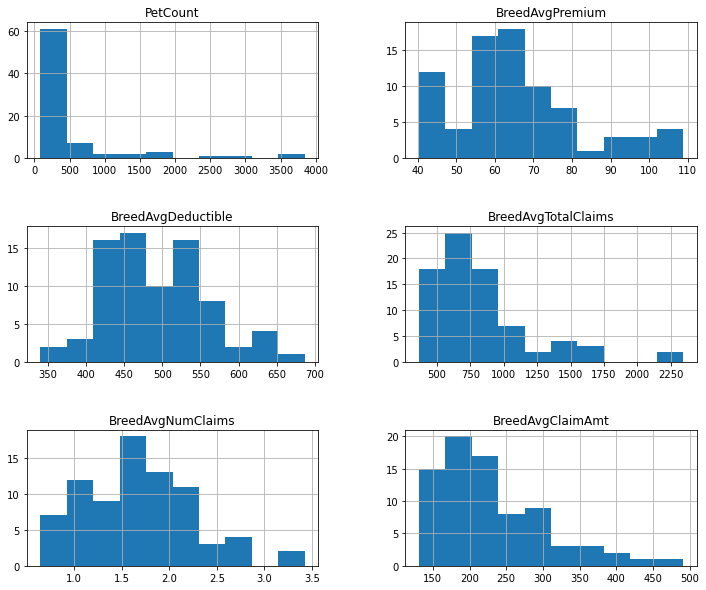

In [9]:
# Preview the distributions of each of our numeric features
breeds.hist(figsize=(12,10))
plt.subplots_adjust(hspace=0.5)
plt.show()

In the distributions above, we see a lot of variability across our different breeds for each of our numeric columns. This provides further evidence that breed matters when it comes to differentiating our pets. As a next step, we'll create a function to add these stats into our train data.

In [10]:
# Create function to pull breed statistics into pets dataframe
def add_breed_stats(df):
    features = ['Breed', 'BreedAvgPremium', 'BreedAvgDeductible', 'BreedAvgTotalClaims',
                'BreedAvgNumClaims', 'BreedAvgClaimAmt']
    breed_stats = breeds.copy()[features]
    df = pd.merge(df, breed_stats, how='left', on='Breed')
    return df

In [11]:
# Apply function to training and test data & preview result
X_train = add_breed_stats(X_train)
X_test = add_breed_stats(X_test)

X_train.head().T

,0,1,2,3,4
Species,Dog,Dog,Dog,Dog,Cat
Breed,Mixed Breed Small,Golden Retriever,Bernese Mountain Dog,Cavalier King Charles Spaniel,Domestic Mediumhair
Premium,23.77,102.66,157.25,54.69,49.77
Deductible,1000,250,200,250,200
AgeYr1,0,0,0,0,1
YoungAge,0,0,0,0,0
AmtClaimsYr1,0.0,0.0,0.0,1435.62,0.0
AvgClaimsYr1,0.0,0.0,0.0,287.124,0.0
NumClaimsYr1,0,0,0,5,0
BreedAvgPremium,60.835549,68.461722,104.423412,63.281374,43.871451


In [12]:
# Check for null values
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Species              40000 non-null  object 
 1   Breed                40000 non-null  object 
 2   Premium              40000 non-null  float64
 3   Deductible           40000 non-null  int64  
 4   AgeYr1               40000 non-null  int64  
 5   YoungAge             40000 non-null  int64  
 6   AmtClaimsYr1         40000 non-null  float64
 7   AvgClaimsYr1         40000 non-null  float64
 8   NumClaimsYr1         40000 non-null  int64  
 9   BreedAvgPremium      40000 non-null  float64
 10  BreedAvgDeductible   40000 non-null  float64
 11  BreedAvgTotalClaims  40000 non-null  float64
 12  BreedAvgNumClaims    40000 non-null  float64
 13  BreedAvgClaimAmt     40000 non-null  float64
dtypes: float64(8), int64(4), object(2)
memory usage: 4.6+ MB


In [13]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Species              10000 non-null  object 
 1   Breed                10000 non-null  object 
 2   Premium              10000 non-null  float64
 3   Deductible           10000 non-null  int64  
 4   AgeYr1               10000 non-null  int64  
 5   YoungAge             10000 non-null  int64  
 6   AmtClaimsYr1         10000 non-null  float64
 7   AvgClaimsYr1         10000 non-null  float64
 8   NumClaimsYr1         10000 non-null  int64  
 9   BreedAvgPremium      10000 non-null  float64
 10  BreedAvgDeductible   10000 non-null  float64
 11  BreedAvgTotalClaims  10000 non-null  float64
 12  BreedAvgNumClaims    10000 non-null  float64
 13  BreedAvgClaimAmt     10000 non-null  float64
dtypes: float64(8), int64(4), object(2)
memory usage: 1.1+ MB


So after pulling in our breed stats, we can see that we don't have any missing values in our data. Next, let's move on to look at Premium and Deductible.

### 4.2 Premium and Deductible
Now that we have the Premium and Deductible rolled up to a breed-level statistic, we should be able to safely drop the pet-level columns. The rationale for this is that customers can select either a premium or a deductible and once one is selected, the other is set automatically. 

This leads to a couple of conclusions:
* At a pet-level, we expect to see a wide range of premiums and deductibles for a single breed (due to customer choice)
* When we average these values out at a breed level, we should see some patterns emerging that might be indicative of the *assumed risk level* for each breed.

Let's take a look.

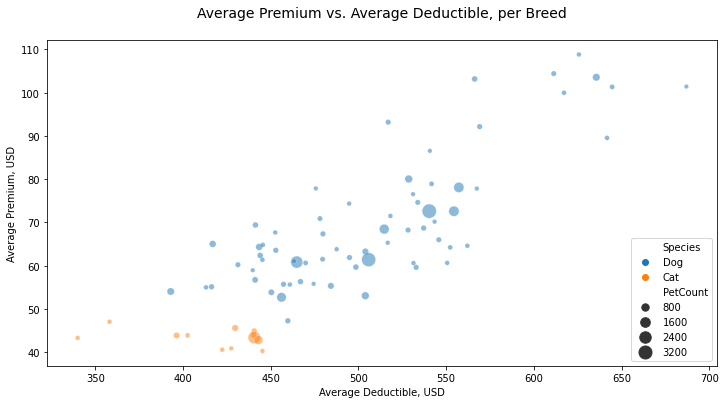

In [14]:
# Create a scatterplot showing spread vs. average total claims
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.scatterplot(y="BreedAvgPremium", x="BreedAvgDeductible", data=breeds, hue="Species", 
                size="PetCount", sizes=(20, 200), alpha=0.5)\
                .set(title="", ylabel="Average Premium, USD",
                     xlabel="Average Deductible, USD")

# Add title and display plot
plt.title("Average Premium vs. Average Deductible, per Breed", y=1.05, fontsize=14)
# plt.suptitle("(TBD)", y=0.95, x=0.513, fontsize=11)
plt.legend(loc='lower right')
plt.show()

The plot above shows a couple of interesting insights.

1. Premiums and deductibles are consistently lower for cats
2. As the average deductible amount goes up for cat breeds, the average premium amount stays roughly the same
3. As the average deductible amount goes up for dog breeds, the average premium amount goes up at a fairly steady linear rate

**So the overall takeaways:**
* Cats seem to be considered lower risk than dogs
* For dog breeds, the premium and deductible amounts vary and could indicate that some breeds are considered riskier to insure than others

Let's drop the pet-level premium and deductible features before moving on.

In [15]:
# Drop Premium and Dedictible columns
X_train = X_train.drop(columns=['Premium', 'Deductible'])
X_test = X_test.drop(columns=['Premium', 'Deductible'])

### 4.3 Pet Age
Summarizing our data by breed helped to highlight an interesting trend in our premium and deductible features. 

**Are there features we could engineer based on the age of our pets at time of enrollment that might help our predictive model?** 

Similar to breed, we would expect a wide range of vairiability in our claims data on a per-pet basis at each age level. However, averaging the claims data per age could help to offset some of that variability we see for individual pets. 

We'll start by grouping our data based on pet age and species.

In [16]:
# Group pets by age at enrollment and aggregate data
pets_by_age = X_train.groupby(by=["AgeYr1", "Species"]).agg({'AgeYr1': ['count'],
                                                             'AmtClaimsYr1': ['mean'],
                                                             'NumClaimsYr1': ['mean'],
                                                             'AvgClaimsYr1': ['mean']}).reset_index()
pets_by_age.columns = ['AgeYr1', 'Species', 'PetCount', 'AgeYr1AvgTotalClaims', 'AgeYr1AvgNumClaims',
                       'AgeYr1AvgClaimAmt']
pets_by_age.head(10).T

,0,1,2,3,4,5,6,7,8,9
AgeYr1,0,0,1,1,2,2,3,3,4,4
Species,Cat,Dog,Cat,Dog,Cat,Dog,Cat,Dog,Cat,Dog
PetCount,3182,22293,724,3044,564,2077,412,1378,316,1142
AgeYr1AvgTotalClaims,435.812674,908.882693,357.384779,700.88929,279.263635,592.255306,244.287864,689.221647,500.15557,778.887723
AgeYr1AvgNumClaims,0.986172,2.000628,0.792818,1.400788,0.544326,1.165142,0.575243,1.216981,0.927215,1.301226
AgeYr1AvgClaimAmt,139.098125,236.73609,132.703879,208.416777,122.143606,183.757834,109.911,222.268512,174.838228,229.990766


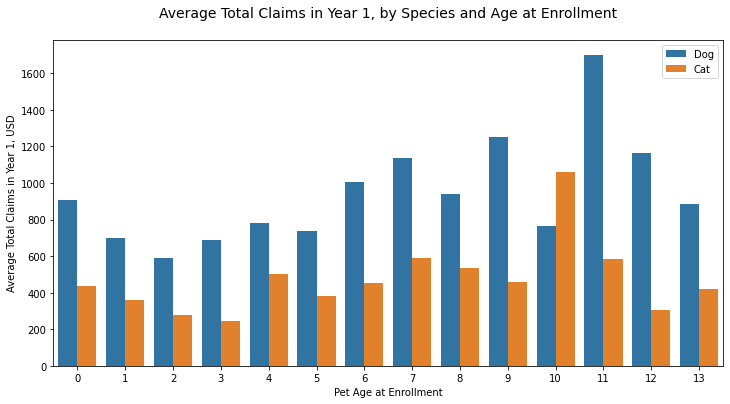

In [17]:
# Plot the data 
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.barplot(x="AgeYr1", y="AgeYr1AvgTotalClaims", hue="Species", data=pets_by_age, hue_order=['Dog', 'Cat'] 
           ).set(xlabel="Pet Age at Enrollment", ylabel="Average Total Claims in Year 1, USD")

# Plot the legend and display
plt.title("Average Total Claims in Year 1, by Species and Age at Enrollment", y=1.05, fontsize=14)
plt.legend(loc='upper right')
plt.show()

As noted in EDA, dogs pretty consistently have higher average total claims than cats at just about every age level with the exception of a couple of ages at the high end of our range. 

There is a bit more variability in the trends for each species across the age range. We see that as age increases, the average claims amount tends to rise, but it's not a clear linear relationship. In any case, incorporating these averages should help our predictive model by adding some population-level features into the mix.  

In [18]:
# Create function to pull age statistics into pets dataframe
def add_age_stats(df):
    features = ['AgeYr1', 'Species', 'AgeYr1AvgTotalClaims', 'AgeYr1AvgNumClaims', 'AgeYr1AvgClaimAmt']
    age_stats = pets_by_age.copy()[features]
    df = pd.merge(df, age_stats, how='left', on=(['AgeYr1', 'Species']))
    return df

In [19]:
# Apply function to training and test data & preview result
X_train = add_age_stats(X_train)
X_test = add_age_stats(X_test)

X_train.head().T

,0,1,2,3,4
Species,Dog,Dog,Dog,Dog,Cat
Breed,Mixed Breed Small,Golden Retriever,Bernese Mountain Dog,Cavalier King Charles Spaniel,Domestic Mediumhair
AgeYr1,0,0,0,0,1
YoungAge,0,0,0,0,0
AmtClaimsYr1,0.0,0.0,0.0,1435.62,0.0
AvgClaimsYr1,0.0,0.0,0.0,287.124,0.0
NumClaimsYr1,0,0,0,5,0
BreedAvgPremium,60.835549,68.461722,104.423412,63.281374,43.871451
BreedAvgDeductible,464.835821,514.685185,611.294118,503.959924,396.326531
BreedAvgTotalClaims,683.756022,906.987716,1423.842235,687.384179,407.453084


## 5. Data Pre-processing
Now that we've engineered a couple of new features, let's take a look at our data and complete any additional pre-processing so we are ready to move on to model creation.

As part of pre-processing, we need to decide what to to with our remaining categorical features - Breed and Species.

Before we start, let's review the dtypes in our dataset.

In [20]:
X_train.dtypes

Species                  object
Breed                    object
AgeYr1                    int64
YoungAge                  int64
AmtClaimsYr1            float64
AvgClaimsYr1            float64
NumClaimsYr1              int64
BreedAvgPremium         float64
BreedAvgDeductible      float64
BreedAvgTotalClaims     float64
BreedAvgNumClaims       float64
BreedAvgClaimAmt        float64
AgeYr1AvgTotalClaims    float64
AgeYr1AvgNumClaims      float64
AgeYr1AvgClaimAmt       float64
dtype: object

Perfect... only two object columns to deal with - Breed and Species. Let's start with Species.

### 5.1 Convert Species to Binary 
For species, we have two possible values - Cat or Dog. To convert this to binary, we'll need to assign each of the possible values as a 1 or 0.

In [21]:
# Create function to convert species to binary
def species_to_binary(df):
    df["Species"] = np.where(df["Species"].str.contains("Dog"), 1, 0)
    return df

In [22]:
# Apply function to training and test data & preview result
X_train = species_to_binary(X_train)
X_test = species_to_binary(X_test)

X_train.head(8).T

,0,1,2,3,4,5,6,7
Species,1,1,1,1,0,1,1,1
Breed,Mixed Breed Small,Golden Retriever,Bernese Mountain Dog,Cavalier King Charles Spaniel,Domestic Mediumhair,Poodle Toy,Cockapoo,Goldendoodle
AgeYr1,0,0,0,0,1,0,2,0
YoungAge,0,0,0,0,0,0,0,0
AmtClaimsYr1,0.0,0.0,0.0,1435.62,0.0,3572.94,0.0,0.0
AvgClaimsYr1,0.0,0.0,0.0,287.124,0.0,396.993333,0.0,0.0
NumClaimsYr1,0,0,0,5,0,9,0,0
BreedAvgPremium,60.835549,68.461722,104.423412,63.281374,43.871451,60.224008,56.30797,52.689605
BreedAvgDeductible,464.835821,514.685185,611.294118,503.959924,396.326531,431.29771,466.954545,456.138647
BreedAvgTotalClaims,683.756022,906.987716,1423.842235,687.384179,407.453084,1076.545687,491.299606,702.688433


In [23]:
# Confirm Species value counts
X_train.Species.value_counts()

1    33580
0     6420
Name: Species, dtype: int64

### 5.2 Convert Breed to Numeric
For 'Breed' we have a different situation given that we have 79 possible unique values in the column. In order to convert this to numeric, we'll need to use one-hot encoding.

In [24]:
# Create function to encode Breed 
def breed_to_numeric(df):
    df = pd.get_dummies(df, columns=['Breed'], prefix="Breed")
    return df

In [25]:
# Preview shape before conversion
shape_before = X_train.shape

# Apply function to df
X_train = breed_to_numeric(X_train)
X_test = breed_to_numeric(X_test)

# Get shape after conversion
shape_after = X_train.shape

# Print results
print("Shape before: " + str(shape_before))
print("Shape after: " + str(shape_after))

Shape before: (40000, 15)
Shape after: (40000, 93)


In [26]:
# Confirm all features are numeric
X_train.dtypes.value_counts()

uint8      79
float64    10
int64       4
dtype: int64

## 6 Model Baseline

* Establish a baseline model using the mean value for AmtClaimsYr2
* Create an initial model
* Save model 

### 5.3 Feature Scaling
At this point, all our features are converted to numeric values. We have two binary columns (Species and YoungAge) and 79 columns resulting from our one-hot encoding of Breed. The remaining features are in different units (e.g., age vs. dollars) and have quite different ranges.

To deal with this variability of ranges, we can normalize our data to get these features on a similar scale.

In [ ]:
# Create a list of the columns for scaling 
cols = ['AgeYr1', 'AmtClaimsYr1', 'AvgClaimsYr1', 'NumClaimsYr1', 'BreedAvgPremium',
        'BreedAvgDeductible','BreedAvgTotalClaims', 'BreedAvgNumClaims', 'BreedAvgClaimAmt',
        'AgeYr1AvgTotalClaims', 'AgeYr1AvgNumClaims', 'AgeYr1AvgClaimAmt']

# Scale selected features 
scaler = MinMaxScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(X_train[cols]), columns=cols)

# Update train dataset with scaled features
for col in cols:
    X_train[col] = scaled_features[col]

In [ ]:
X.head(12).T

In [ ]:
# # Create function for plotting scatterplots of Total Claims in Year 2 against desired columns
# def scatterplots(df, y, columns, ncol=None, figsize=(15, 8)):
#     if ncol is None:
#         ncol = len(columns)
#     nrow = int(np.ceil(len(columns) / ncol))
#     fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
#     fig.subplots_adjust(wspace=0.5, hspace=0.6)
#     for i, col in enumerate(columns):
#         ax = axes.flatten()[i]
#         ax.scatter(x=col, y=y, data=df, alpha=0.5)
#         ax.set(xlabel=col, ylabel='Total Claims Yr 2, USD')
#     nsubplots = nrow * ncol    
#     for empty in range(i+1, nsubplots):
#         axes.flatten()[empty].set_visible(False)

In [ ]:
# Call the function to create the scatterplots

# y = pd.Series(y_train)
# scatterplots(X_train, y, cols, ncol=4, figsize=(16,8))

# TODO - Possible Next Steps

2. Establish a model baseline and/or train an initial model
3. Apply all preprocessing steps to the test data
4. Write up summary, conclusions and next steps for modeling
5. Save any necessary data files or models